### Natural Language Processing Final Assignment - Emotion Analysis over Tweets from Twitter social website 

Team Members :  
1. Sameer Shaik
2. Grishma Reddy Narigela 
3. Nithin Naga Sai Gajula

### Importing Libraries & Mapping

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import os

# Set seed for reproducibility
def seed_all(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all()


### Preprocessing Data and EDA

In [2]:
# Load your train.txt
data_path = "train.txt"
texts, labels = [], []

with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        if ";" in line:
            text, label = line.strip().split(";")
            texts.append(text)
            labels.append(label)

# Map emotions to unique integers
unique_labels = sorted(set(labels))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

labels_num = [label2id[l] for l in labels]

print("Classes:", label2id)


Classes: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


### Tokenizer and Vocabulary

In [3]:
def build_vocab(texts, min_freq=1):
    counter = Counter(word for text in texts for word in text.split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def tokenize(text, vocab):
    return [vocab.get(w, vocab['<UNK>']) for w in text.split()]

vocab = build_vocab(texts)
print("Vocab size:", len(vocab))


Vocab size: 15214


### Dataset and Dataloader

In [4]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=30):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx], self.vocab)
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))
        else:
            tokens = tokens[:self.max_len]
        return torch.tensor(tokens), torch.tensor(self.labels[idx])

dataset = TextDataset(texts, labels_num, vocab)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


### Applying FCNN model

In [5]:
class FCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model_fcnn = FCNN(len(vocab), 50, len(label2id))


### Training the model

In [6]:
optimizer = optim.Adam(model_fcnn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 5

for epoch in range(epochs):
    model_fcnn.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model_fcnn(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 788.1464
Epoch 2: Loss = 728.3516
Epoch 3: Loss = 585.6995
Epoch 4: Loss = 430.0563
Epoch 5: Loss = 318.8329


### Evaluating the FCNN Model and Confusion MAtrix

Accuracy: 0.8194375
              precision    recall  f1-score   support

       anger       0.66      0.75      0.70      2159
        fear       0.77      0.70      0.73      1937
         joy       0.85      0.96      0.90      5362
        love       0.80      0.39      0.53      1304
     sadness       0.88      0.95      0.91      4666
    surprise       0.90      0.02      0.03       572

    accuracy                           0.82     16000
   macro avg       0.81      0.63      0.64     16000
weighted avg       0.82      0.82      0.80     16000



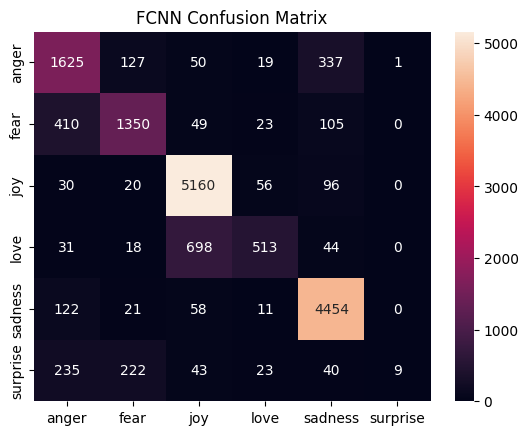

In [7]:
model_fcnn.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x_batch, y_batch in loader:
        output = model_fcnn(x_batch)
        preds = torch.argmax(output, dim=1)
        y_true += y_batch.tolist()
        y_pred += preds.tolist()

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=label2id.keys()))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.title("FCNN Confusion Matrix")
plt.show()


### Defining LSTM Model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden.squeeze(0))

model_lstm = LSTMModel(len(vocab), embed_dim=50, hidden_dim=64, output_dim=len(label2id))


### Training the model

In [9]:
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
loss_fn_lstm = nn.CrossEntropyLoss()
epochs = 5

for epoch in range(epochs):
    model_lstm.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer_lstm.zero_grad()
        output = model_lstm(x_batch)
        loss = loss_fn_lstm(output, y_batch)
        loss.backward()
        optimizer_lstm.step()
        total_loss += loss.item()
    print(f"[LSTM] Epoch {epoch+1}: Loss = {total_loss:.4f}")


[LSTM] Epoch 1: Loss = 792.2065
[LSTM] Epoch 2: Loss = 787.3556
[LSTM] Epoch 3: Loss = 737.8611
[LSTM] Epoch 4: Loss = 561.2991
[LSTM] Epoch 5: Loss = 436.7279


### Evaluating the LSTM Model

🔍 LSTM Accuracy: 0.7489375
              precision    recall  f1-score   support

       anger       0.59      0.78      0.67      2159
        fear       0.73      0.40      0.51      1937
         joy       0.77      0.95      0.85      5362
        love       0.61      0.03      0.06      1304
     sadness       0.81      0.94      0.87      4666
    surprise       0.69      0.02      0.03       572

    accuracy                           0.75     16000
   macro avg       0.70      0.52      0.50     16000
weighted avg       0.74      0.75      0.70     16000



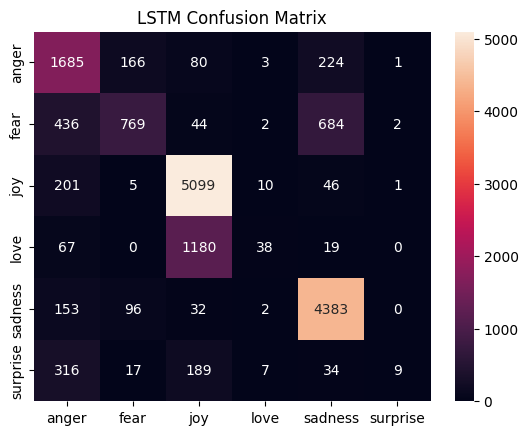

In [10]:
model_lstm.eval()
y_true_lstm, y_pred_lstm = [], []

with torch.no_grad():
    for x_batch, y_batch in loader:
        output = model_lstm(x_batch)
        preds = torch.argmax(output, dim=1)
        y_true_lstm.extend(y_batch.tolist())
        y_pred_lstm.extend(preds.tolist())

print("🔍 LSTM Accuracy:", accuracy_score(y_true_lstm, y_pred_lstm))
print(classification_report(y_true_lstm, y_pred_lstm, target_names=label2id.keys()))

cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt="d", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.title("LSTM Confusion Matrix")
plt.show()


### Finetuning the Transformer

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


df_trans = pd.DataFrame({"text": texts, "label": labels_num})
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoded = tokenizer(df_trans["text"].tolist(), truncation=True, padding=True, max_length=64)


hf_dataset = Dataset.from_dict({
    "input_ids": encoded["input_ids"],
    "attention_mask": encoded["attention_mask"],
    "label": df_trans["label"]
})


model_transformer = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id)
)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="weighted")
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


training_args = TrainingArguments(
    output_dir="./results_transformer",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs_transformer",
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model_transformer,
    args=training_args,
    train_dataset=hf_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-13-4102630519.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.716100
20,1.603500
30,1.567000
40,1.372000
50,1.237600
60,1.178200
70,0.996300
80,0.878300
90,0.915700
100,0.761200


TrainOutput(global_step=3000, training_loss=0.20308240178227424, metrics={'train_runtime': 295.8196, 'train_samples_per_second': 162.261, 'train_steps_per_second': 10.141, 'total_flos': 794861088768000.0, 'train_loss': 0.20308240178227424, 'epoch': 3.0})

### Evaluating the model and comparing all the models

 Transformer Accuracy: 0.9763125
              precision    recall  f1-score   support

       anger       0.98      0.98      0.98      2159
        fear       0.92      0.99      0.96      1937
         joy       0.98      0.99      0.99      5362
        love       0.95      0.94      0.94      1304
     sadness       0.99      0.99      0.99      4666
    surprise       0.98      0.80      0.88       572

    accuracy                           0.98     16000
   macro avg       0.97      0.95      0.96     16000
weighted avg       0.98      0.98      0.98     16000



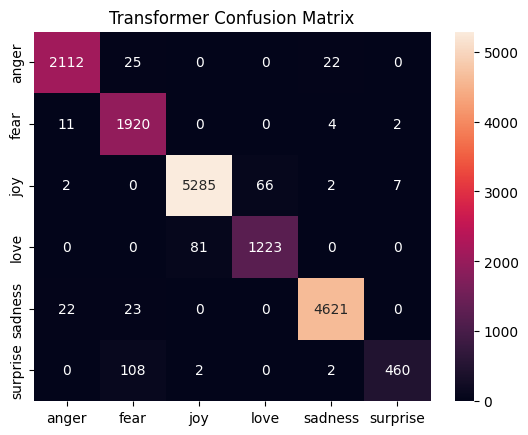


 FCNN
Accuracy: 0.8194375
              precision    recall  f1-score   support

       anger       0.66      0.75      0.70      2159
        fear       0.77      0.70      0.73      1937
         joy       0.85      0.96      0.90      5362
        love       0.80      0.39      0.53      1304
     sadness       0.88      0.95      0.91      4666
    surprise       0.90      0.02      0.03       572

    accuracy                           0.82     16000
   macro avg       0.81      0.63      0.64     16000
weighted avg       0.82      0.82      0.80     16000


 LSTM
Accuracy: 0.7489375
              precision    recall  f1-score   support

       anger       0.59      0.78      0.67      2159
        fear       0.73      0.40      0.51      1937
         joy       0.77      0.95      0.85      5362
        love       0.61      0.03      0.06      1304
     sadness       0.81      0.94      0.87      4666
    surprise       0.69      0.02      0.03       572

    accuracy           

In [14]:

preds_transformer = trainer.predict(hf_dataset)
y_pred_transformer = preds_transformer.predictions.argmax(-1)
y_true_transformer = preds_transformer.label_ids

print(" Transformer Accuracy:", accuracy_score(y_true_transformer, y_pred_transformer))
print(classification_report(y_true_transformer, y_pred_transformer, target_names=label2id.keys()))

cm_transformer = confusion_matrix(y_true_transformer, y_pred_transformer)
sns.heatmap(cm_transformer, annot=True, fmt="d", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.title("Transformer Confusion Matrix")
plt.show()


def evaluate(name, y_true, y_pred):
    print(f"\n {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=label2id.keys()))

evaluate("FCNN", y_true, y_pred)
evaluate("LSTM", y_true_lstm, y_pred_lstm)
evaluate("Transformer", y_true_transformer, y_pred_transformer)


### Finding out the best model

In [19]:
from sklearn.metrics import f1_score

# Compute macro F1 scores
f1_scores = {
    "FCNN": f1_score(y_true, y_pred, average="macro"),
    "LSTM": f1_score(y_true_lstm, y_pred_lstm, average="macro"),
    "Transformer": f1_score(y_true_transformer, y_pred_transformer, average="macro")
}

# Find the best model
best_model = max(f1_scores, key=f1_scores.get)
best_score = f1_scores[best_model]

print(f"\n Best Model: {best_model} with Macro F1-score = {best_score:.4f}")



 Best Model: Transformer with Macro F1-score = 0.9570


In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the trainer
predictions = trainer.predict(hf_dataset)

# Predicted probabilities (logits → softmax)
probs = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities
from scipy.special import softmax
probs_soft = softmax(probs, axis=1)


### AUC ROC Curves for the models

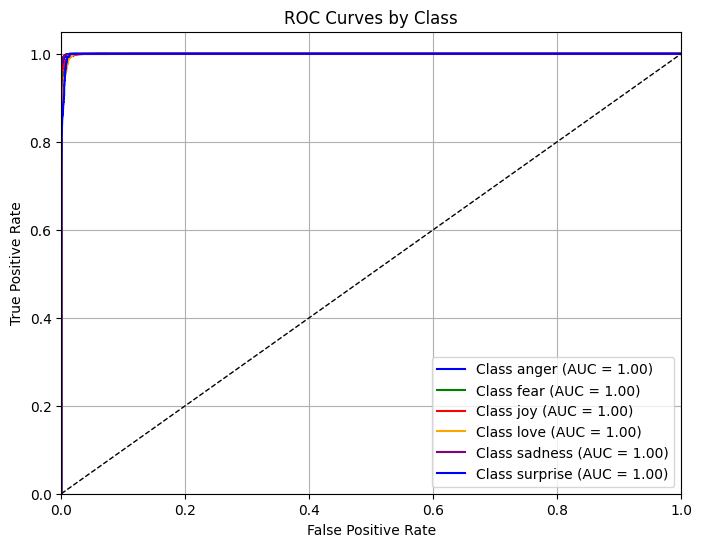

In [18]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC (one-hot encoding)
n_classes = len(label2id)
labels_bin = label_binarize(labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_soft[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for i, label_name in enumerate(label2id.keys()):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"Class {label_name} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
